In [1]:
import sys
import clipboard
import gc
import PIL, numpy as np, cv2
from PIL.ImageGrab import grab as screenshot
from PIL import Image
sys.path.append('C:\\Users\\Administrator\\source\\repos\\mycvtools\\x64\\Release\\')
import mycvtools
import importlib
import os
import utils
utils = importlib.reload(utils)

In [2]:
def mask_background(img):
    rv = img.copy()
    mycvtools.mask_background(rv)
    return rv

def mask_noncolor(img):
    rv = img.copy()
    mycvtools.mask_grayscale(rv)
    return rv

In [3]:
fp = "C:\\Users\\Administrator\\Dropbox\\Python\\jpnotebooks\\other\\ngu\\images"
images = []

ncols = 5
maxrow = 0
heights = [0, 0]
row = 0
for i, file in enumerate(os.listdir(fp), 1):
    if file == ("inventory.bmp"): continue
    img = cv2.imread(os.path.join(fp, file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append((img, mask_background(img), mask_noncolor(img)))
    row += img.shape[1]
    if img.shape[0] > heights[-1]:
        heights[-1] = img.shape[0]
    if i % ncols == 0:
        if row > maxrow:
            maxrow = row
        row = 0
        heights.append(0)
        
for i in range(1, len(heights)):
    heights[i] += heights[i - 1]

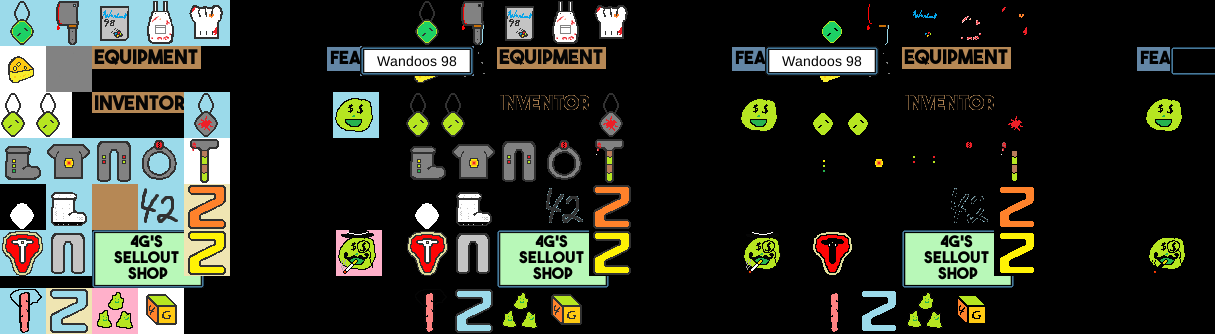

In [4]:
aimg = Image.new('RGB', (maxrow*3, heights[-1]))
lastw = 0
lasth = 0
for i, (img, img2, img3) in enumerate(images):
    pimg = Image.fromarray(img, "RGB")
    aimg.paste(pimg, ((i % 5) * lastw, heights[i // 5]))
    pimg2 = Image.fromarray(img2, "RGB")
    aimg.paste(pimg2, ((i % 5) * lastw + maxrow, heights[i//5]))
    pimg3 = Image.fromarray(img3, "RGB")
    aimg.paste(pimg3, ((i % 5) * lastw + maxrow*2, heights[i//5]))
    lastw = pimg.width
aimg

In [73]:
import imagehash

imdir = "C:\\Users\Administrator\\Dropbox\\Python\\jpnotebooks\\other\\ngu\\images"

def load_image(fp):
    afp = os.path.abspath(fp)
    if os.path.exists(afp):
        img = cv2.imread(afp)
    else:
        afp = os.path.join(imdir, fp)
        img = cv2.imread(afp)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def mask_background(img):
    rv = img.copy()
    mycvtools.mask_background(rv)
    return rv

def mask_noncolor(img):
    rv = img.copy()
    mycvtools.mask_grayscale(rv)
    return rv

def mask_empty(img):
    rv = np.zeros_like(img)
    return rv

def mask_none(img):
    return img.copy()

def color_segment(c):
    r,g,b = c
    size = 16
    return r-(r%size), g-(g%size), b-(b%size)

def hash_image(img):
    return str(imagehash.average_hash(img))

class ReferenceImage():
    def __init__(self, img, maskfunc, classifier='unknown', name=None, raw_compare=None):
        self._img = np.asarray(img)
        self._name = name
        self._maskfunc = maskfunc
        self._masked = maskfunc(self._img)
        self._color = mycvtools.average_color(self._masked)
        self._classifier = classifier
        self._base_hash = hash_image(Image.fromarray(self._img))
        self._color_segment = color_segment(self._color)
        self.raw_compare = raw_compare
        
    def asimage(self):
        return Image.fromarray(self._img)
        
    @property
    def name(self):
        return self._name
    
    @classmethod
    def fromfile(cls, fp, maskfunc, classifier='unknown', name=None, raw_compare=None):
        img = load_image(fp)
        name = name or os.path.splitext(os.path.split(fp)[1])[0]
        return cls(img, maskfunc, classifier, name, raw_compare)
    
    def show(self):
        aimg = Image.new("RGB", (self._img.shape[0] + self._masked.shape[0], max(self._img.shape[1], self._masked.shape[1])))
        aimg.paste(Image.fromarray(self._img), (0, 0))
        aimg.paste(Image.fromarray(self._masked), (self._img.shape[0], 0))
        return aimg
    
    def get_base_hash(self):
        return self._base_hash
    
    def get_color_segment(self):
        return self._color_segment
    
    def __eq__(self, other):
        if not isinstance(other, ReferenceImage):
            return NotImplemented
        if self._classifier != other._classifier:
            return False
        dsq = mycvtools.color_distsq(self._color, other._color)
        if dsq < 100:
            return True
        return False
    
_default_masks = {
    'necklace': mask_noncolor,
    'hammer': mask_background,
    'wandoos': mask_background,
    'EMPTY': mask_none,
}
           
class _ImageSegmentList():
    def __init__(self, classifier, mask=mask_background):
        self._classifier = classifier
        self._mask = mask
        self._images = {}
        
    def add(self, img):
        cs = img.get_color_segment()
        ref = self._images.get(cs, None)
        if ref is not None:
            raise ValueError("Duplicate entry creating reference list: '%s' == '%s'" % (img._name, ref._name))
        self._images[cs] = img
        
    def get_classifier(self):
        return self._classifier
        
    def __iter__(self):
        return iter(self._images)
    
    def empty(self):
        return not self._images
    
    def lookup_raw(self, ss):
        masked = self._mask(np.asarray(ss))
        color = mycvtools.average_color(masked)
        seg = color_segment(color)
        im = self._images.get(seg, None)
        if im is not None and im.raw_compare:
            if not im.raw_compare(ref, ss):
                return None
        return im
    
from collections import defaultdict
class ReferenceList():
    def __init__(self):
        self._data = {}
        self._files = {}  # filename lookup
        
    def _get_or_create_key(self, key, classifier='unknown'):
        if key not in self._data:
            mask = _default_masks.get(classifier, mask_background)
            self._data[key] = _ImageSegmentList(classifier, mask)
        segments = self._data[key]
        if classifier != segments.get_classifier():
            raise ValueError("Ambiguous classifier detected creating Reference list: '%s' != '%s'" % (classifier, segments.get_classifier)())
        return segments
    
    def add(self, ref):
        h1 = ref.get_base_hash()
        segments = self._get_or_create_key(h1, ref._classifier)
        segments.add(ref)
        return ref
        
    def addfile(self, fp, maskfunc, classifier='unknown', name=None, raw_compare=None):
        ref = ReferenceImage.fromfile(fp, maskfunc, classifier, name, raw_compare)
        self._files[fp] = ref
        return self.add(ref)
        
    def lookup(self, ss):
        h = hash_image(ss)
        segments = self._data.get(h, None)
        if segments is None: 
            return None
        return segments.lookup_raw(ss)

In [74]:
RefList = ReferenceList()

asc_forest_pendant = RefList.addfile("ascended_forest_pendant.bmp", mask_noncolor, 'necklace')
forest_pendant = RefList.addfile("forest_pendant.bmp", mask_noncolor, 'necklace')
mole_hammer = RefList.addfile("mole_hammer.bmp", mask_background, "hammer")

wandoos98 = RefList.addfile("busted_copy_of_wandoos98.bmp", mask_background, 'wandoos')
combat_cheese = RefList.addfile("combat_cheese.bmp", mask_background, "cheese_wedge")
looty_mclootface = RefList.addfile("looty_mclootface.bmp", mask_background, "looty_mclootface")
tutorial_cube = RefList.addfile("tutorial_cube.bmp", mask_background, "cube")

empty_inventory = RefList.addfile("empty_inventory.bmp", mask_none, "EMPTY")
no_inventory = RefList.addfile("no_inventory.bmp", mask_none, "EMPTY")

magitech_amulet = RefList.addfile("magitech_amulet.bmp", mask_noncolor, 'necklace')
magitech_boots = RefList.addfile("magitech_boots.bmp", mask_background, "boots")
magitech_chestplate = RefList.addfile("magitech_chestplate.bmp", mask_background, "chestplate")
magitech_leggings = RefList.addfile("magitech_leggings.bmp", mask_background, "leggings")
magitech_ring = RefList.addfile("magitech_ring.bmp", mask_background, "ring")

nonslip_shoes = RefList.addfile("nonslip_shoes.bmp", mask_background, "boots")
chef_apron = RefList.addfile("chef_apron.bmp", mask_background, "apron")
raw_slab_of_meat = RefList.addfile("raw_slab_of_meat.bmp", mask_background, "meat_slab")
suspicious_sausage = RefList.addfile("suspicious_sausage.bmp", mask_background, "sausage")
bloody_cleaver = RefList.addfile('bloody_cleaver.bmp', mask_background, "bloody_cleaver")
chef_hat = RefList.addfile('chef_hat.bmp', mask_background, "chef_hat")
regular_pants = RefList.addfile('regular_pants.bmp', mask_background, "regular_pants")

power2 = RefList.addfile("power2.bmp", mask_background, "boost2")
special2 = RefList.addfile("special2.bmp", mask_background, "boost2")
toughness2 = RefList.addfile("toughness2.bmp", mask_background, "boost2")

# for file in os.listdir("./images"):
#     if file not in RefList._files:
#         print("%s = RefList.addfile('%s', mask_background, \"%s\")"%(file[:file.rfind(".")], file, file[:file.rfind(".")]))

number_42 = RefList.addfile('number_42.bmp', mask_background, "number_42")
sir_looty_mclootington = RefList.addfile('sir_looty_mclootington.bmp', mask_background, "sir_looty_mclootington")
triple_flubber = RefList.addfile('triple_flubber.bmp', mask_background, "triple_flubber")

In [134]:
# inventory parsing requires precisely determining the location of the inventory boxes
# the easiest way is just to scan for the correctly colored pixels
# use the location of the "INVENTORY" text as the reference point, due to its thick text

def _find_nonwhite_start(header):
    ss = screenshot()
    arr = np.asarray(ss)
    tmpl = cv2.cvtColor(header, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.cvtColor(arr, cv2.COLOR_BGR2GRAY)
    h, w = tmpl.shape
    res = cv2.matchTemplate(img_gray, tmpl, cv2.TM_CCOEFF_NORMED)
    _, val, _, (x,y) = cv2.minMaxLoc(res)
    if val < 0.95:
        raise ValueError("Failed to find location")
    
    xh, yh = x, y 
    y += h
    x += w // 2  # start from bottom middle of discovered rect

    white = color_segment((255, 255, 255))
    # scan down till white
    while True:
        color = arr[y, x]
        seg = color_segment(color)
        if seg == white:
            break
        y += 1
        
    # scan left till not white
    x -= 1
    while True:
        color = arr[y, x]
        seg = color_segment(color)
        if seg != white:
            break
        x -= 1
        
    # backup to the last white square
    x += 1  

    return xh, yh, x, y

def _get_inventory(x, y):
    rows = 5
    columns = 12
    side = 50  # size in px of each inventory square, including pad
    height = rows * side
    width = columns * side
    return Region(x, y, width, height)

class BaseInventory():
    maxrows = 1
    maxcolumns = 1
    def __init__(self, header, header_region, region):
        self._header = header
        self._header_region = header_region
        self._region = region
        
    def grab(self):
        return self._region.grab()
        
    def get(self, idx):
        # return inventory cell, with padding removed
        row = idx // self.maxrows
        col = idx % self.maxcolumns
        return self.get2(row, col)
        
    def get2(self, row, col):
        if row < 0 or row >= self.maxrows or col < 0 or col >= self.maxcolumns:
            raise IndexError("(%d, %d)"%(row, col))
        return self.get_unsafe(row, col)
    
    def get_unsafe(self, row, col):
        y = row * 50 + self._region.y
        x = col * 50 + self._region.x
        return Region(x + 2, y + 2, 46, 46)
    
# simple
class Inventory(BaseInventory):
    maxrows = 5
    maxcolumns = 12

# all same base methods, but indices are laid out
# in a much less straightforward way
class Equipment(BaseInventory):
    maxrows = 4
    maxcolumns = 4
    def __init__(self, *args):
        super().__init__(*args)
        self._valid = [
            [1, 1, 0, 0],
            [1, 1, 1, 1],
            [0, 1, 0, 0],
            [0, 1, 0, 1],
        ]
    def get2(self, row, col):
        if self._valid[row][col] == 0:
            raise IndexError("(%d, %d)"%(row, col))
        return self.get_unsafe(row, col)
    
    @property
    def helm(self):
        return self.get2(0, 1)
    @property
    def chest(self):
        return self.get2(1, 1)
    @property
    def legs(self):
        return self.get2(2, 1)
    @property
    def boots(self):
        return self.get2(3, 1)
    @property
    def weapon(self):
        return self.get2(1, 2)
    @property
    def cube(self):
        return self.get2(1, 3)
    @property
    def acc1(self):
        return self.get2(0, 0)
    @property
    def acc2(self):
        return self.get2(1, 0)
    @property
    def trash(self):
        return self.get2(3, 3)
    
def init_inventory():
    header = load_image("inventory_header.png")
    xh, yh, x, y = _find_nonwhite_start(header)
    print(x,y)
    h, w = header.shape[:2]
    header_region = Region(xh, yh, w, h)
    region = _get_inventory(x, y)
    return Inventory(header, header_region, region)

def init_equipment():
    header = load_image("equipment_header.png")
    xh, yh, x, y = _find_nonwhite_start(header)
    h, w = header.shape[:2]
    header_region = Region(xh, yh, w, h)
    region = Region(x, y, Equipment.maxcolumns * 50, Equipment.maxrows * 50)
    return Equipment(header, header_region, region)

486 540


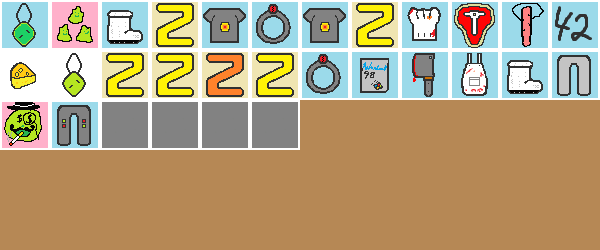

In [135]:
inv = init_inventory()
inv.grab()

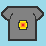

In [136]:
equip = init_equipment()
equip.chest.grab()

In [141]:
RefList.lookup(equip.chest.grab()).mask

AttributeError: 'ReferenceImage' object has no attribute 'mask'

0 (3, 3): ascended_forest_pendant
1 (53, 3): triple_flubber
2 (103, 3): nonslip_shoes
3 (153, 3): special2
4 (203, 3): magitech_chestplate
5 (253, 3): magitech_ring
6 (303, 3): magitech_chestplate
7 (353, 3): special2
8 (403, 3): chef_hat
9 (453, 3): raw_slab_of_meat
10 (503, 3): suspicious_sausage
11 (553, 3): number_42
12 (3, 53): combat_cheese
13 (53, 53): forest_pendant
14 (103, 53): special2
15 (153, 53): special2
16 (203, 53): power2
17 (253, 53): special2
18 (303, 53): magitech_ring
19 (353, 53): busted_copy_of_wandoos98
20 (403, 53): bloody_cleaver
21 (453, 53): chef_apron
22 (503, 53): nonslip_shoes
23 (553, 53): regular_pants
24 (3, 103): sir_looty_mclootington
25 (53, 103): magitech_leggings
26 (103, 103): empty_inventory
27 (153, 103): empty_inventory
28 (203, 103): empty_inventory
29 (253, 103): empty_inventory
30 (303, 103): no_inventory


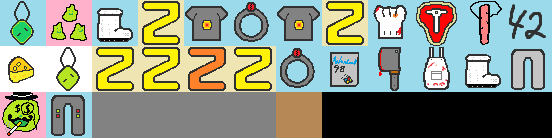

In [22]:
x,y = find_inventory_start()
inventory =  (x, y, 1102, 807)
img = screenshot(inventory)
# extract the inventory spaces
# this image is off-aligned by exactly 1 pixel in x and y from the top left
# each inventory space is padded on either side by 2 pixels (total of 4 between each)
# and is 46 * 46 pixels
side = 46
pad = 2
columns = 12
total = 27
aimg = PIL.Image.new("RGB", (columns*46, 3 * 46))
tiles = []
i = 0
while True:
    col = (i % columns)
    row = (i // columns)
    
    # skip the offset pixel + the first two pad pixels 
    # on the top and left of the topleft cell
    x = col * side + (pad * col * 2 + 3)
    y = row * side + (pad * row * 2 + 3)
    #print(row, col, x, y)
    tile = img.crop((x, y, x+side, y+side))
    aimg.paste(tile, (46*col,46*row))
    tiles.append(tile)
    match = RefList.lookup(tile)
    if match:
        print("%d (%d, %d): %s"%(i, x, y,match.name))
    else:
        print("%d (%d, %d): %s"%(i, x, y, "<no match>"))
    if match == no_inventory:
        break
    i += 1
aimg

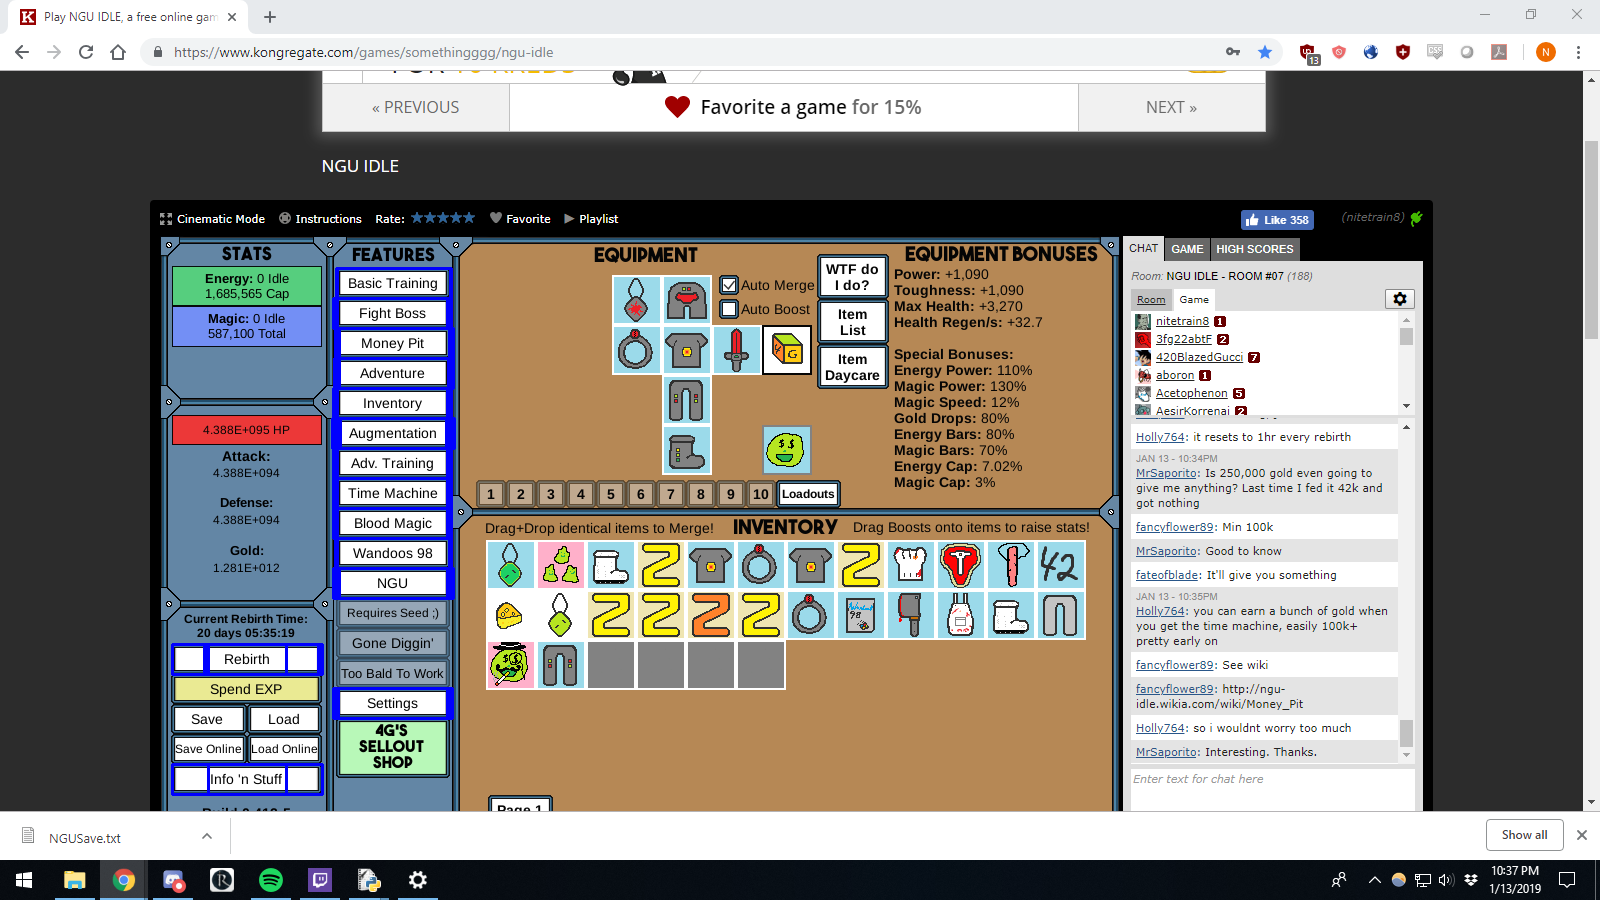

In [23]:
tmpl = load_image("features_wandoos98.png")
tmpl = cv2.cvtColor(tmpl, cv2.COLOR_BGR2GRAY)
img = np.asarray(screenshot())
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
res = cv2.matchTemplate(img_gray, tmpl, cv2.TM_CCOEFF_NORMED)
loc = np.where(res >= 0.75)
h, w = tmpl.shape
#_, _, _, loc = cv2.minMaxLoc(res)
for pt in zip(*loc[::-1]):
    cv2.rectangle(img, pt, (pt[0] + w, pt[1]+h), (0, 0, 255), 2)
Image.fromarray(img)

In [66]:
utils = importlib.reload(utils)

def _grayify(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def _match(img, ref, flag=cv2.TM_CCOEFF_NORMED):
    return cv2.matchTemplate(ref, img, flag)

def _find_image_in_image(image, reference):
    image = np.asarray(image)
    reference = np.asarray(reference)
    igray = _grayify(image)
    rgray = _grayify(reference)
    return _match(igray, rgray)
    
class NotFound(ValueError):
    pass
    
class Region():
    def __init__(self, x, y, w, h):
        self.x = x
        self.y = y
        self.w = w
        self.h = h
    
    def get_bbox(self):
        return self.x, self.y, self.x + self.w, self.y + self.h
    
    def grab(self):
        return screenshot(self.get_bbox())
    
    def _find_inner(self, img, thresh):
        ref = self.grab()
        img = np.asarray(img)
        ref = np.asarray(ref)
        res = _find_image_in_image(img, ref)
        h, w = img.shape[:2]
        return res, h, w
        
    def find(self, img, thresh=0.95):
        res, h, w = self._find_inner(img, thresh)
        _, val, _, loc = cv2.minMaxLoc(res)
        if val < thresh:
            raise NotFound("Failed to find image")
        x, y = loc
        return self.__class__(x, y, w, h)
    
    def get_middle(self):
        return self.x + self.w / 2, self.y + self.h / 2
    
    def click(self):
        x, y = self.get_middle()
        utils.left_click(x, y)
        
    def dragto(self, other, delay=0.01):
        if isinstance(other, Region):
            x2, y2 = other.get_middle()
        else:
            x2, y2 = other
        
        x1, y1 = self.get_middle()
        
        x1, y1 = utils.norm(x1, y1)
        x2, y2 = utils.norm(x2, y2)
        utils.drag(x1, y1, x2, y2, delay)
#         import time
#         ip1 = utils._mouse_event(x1, y1, utils.MOUSEEVENTF_ABSOLUTE | utils.MOUSEEVENTF_VIRTUALDESK | utils.MOUSEEVENTF_MOVE | utils.MOUSEEVENTF_LEFTDOWN)
#         ip2 = utils._mouse_event(x2, y2, utils.MOUSEEVENTF_ABSOLUTE | utils.MOUSEEVENTF_VIRTUALDESK | utils.MOUSEEVENTF_MOVE)
#         ip3 = utils._mouse_event(0, 0, utils.MOUSEEVENTF_ABSOLUTE | utils.MOUSEEVENTF_VIRTUALDESK | utils.MOUSEEVENTF_LEFTUP)
#         utils.send_inputs(ip1)
#         time.sleep(0.5)
#         utils.send_inputs(ip2)
#         time.sleep(0.5)
#         utils.send_inputs(ip3)
#         time.sleep(0.5)
#         utils.mouse_move(x1, y1)
        
#         utils.mouse_move(x2, y2)
#         time.sleep(0.5)
    
    def dragfrom(self, other):
        other.dragto(self)
            
    def findall(self, img, thresh=0.95):
        res, h, w = self._find_inner(img, thresh)
        loc = np.where(res >= thresh)
        rv = []
        for y, x in zip(*loc):
            r = self.__class__(x, y, w, h)
            rv.append(r)
        return rv
    
    def apply_rectangles(self, regions, color=(0,0,255)):
        if isinstance(regions, Region):
            regions = [regions]  # convenience
        img = self.grab()
        img = np.asarray(img)
        for r in regions:
            x0, y0, x1, y1 = r.get_bbox()
            cv2.rectangle(img, (x0, y0), (x1, y1), color, 2)
        return Image.fromarray(img)
    
    def abs_to_rel(self, other):
        x = other.x - self.x
        y = other.y - self.y
        return self.__class__(x, y, other.w, other.h)
    

In [70]:
screen = Region(0, 0, 1600, 900)
asc_pend = screen.find(asc_forest_pendant.asimage())
matches = screen.findall(special2.asimage())
for m in matches:
    m.dragto(asc_pend, 0.02)

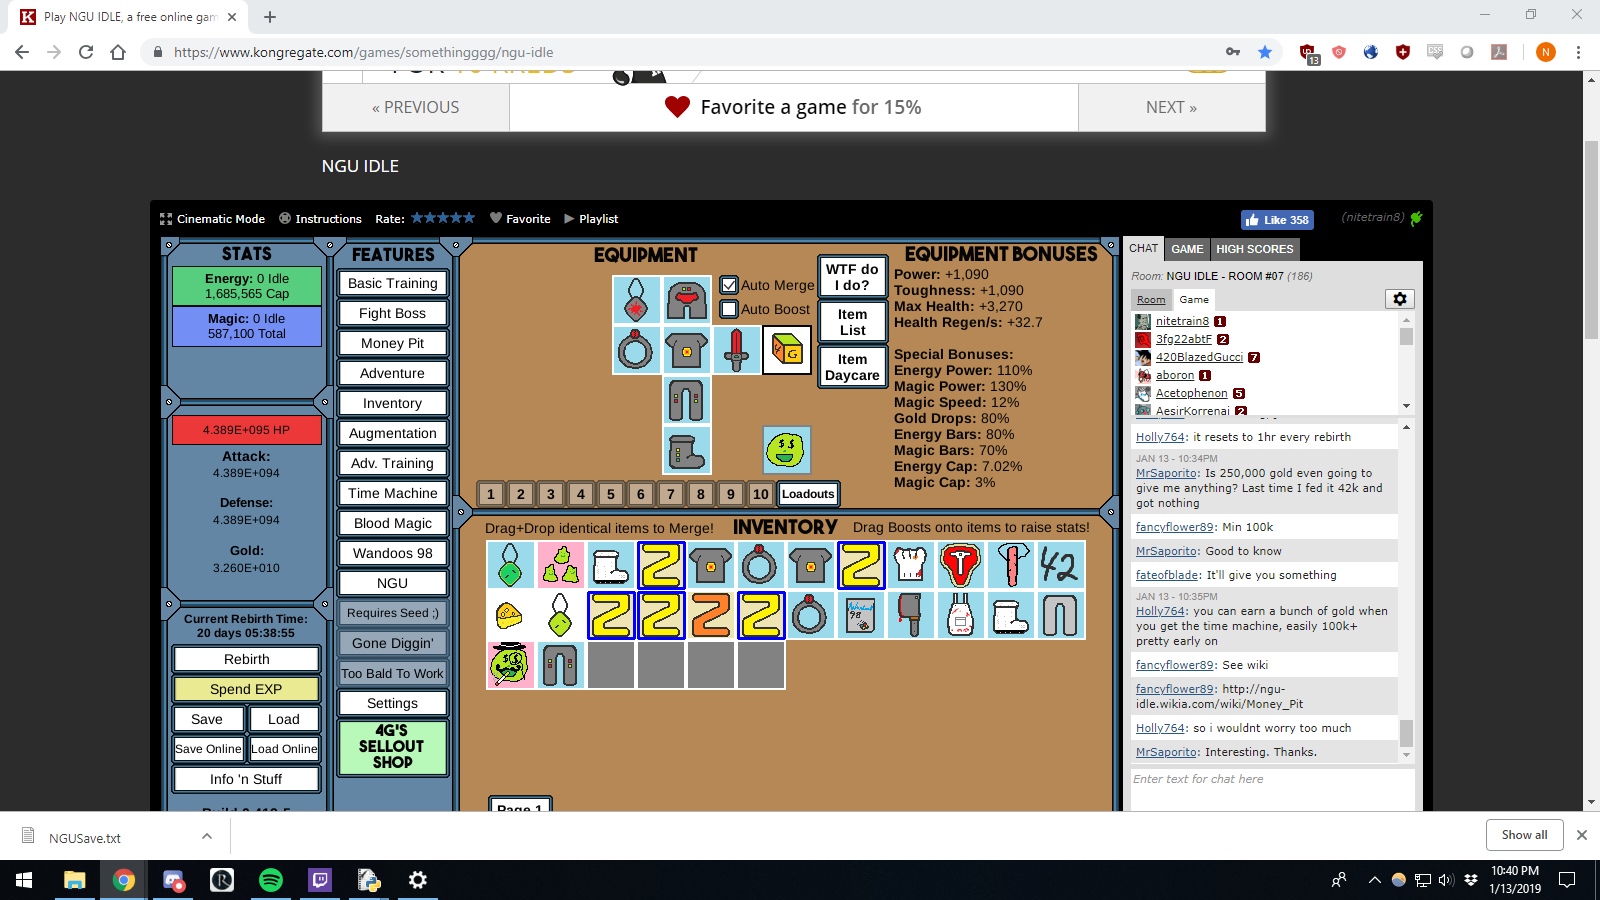

In [31]:
screen = Region(0, 0, 1600, 900)
r = Region(153+485, 3+539, 46, 46)
matches = screen.findall(r.grab())
screen.apply_rectangles(matches)